# 2020 Ridge Only

## 1. Data Cleaning 

### 1.1 Filter by 2023 Winter Quarter

In [40]:
import pandas as pd
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv("Full_Data.csv")

# Convert date and time columns into datetime
df['Received Timestamp'] = pd.to_datetime(df['Received Date'] + ' ' + df['Received Time'])
df['Delivered Timestamp'] = pd.to_datetime(df['Delivered Date'] + ' ' + df['Delivered Time'])

# Drop original date and time columns if no longer needed
df = df.drop(columns=['Received Date', 'Received Time', 'Delivered Date', 'Delivered Time'])

# Ensure proper datatypes
df['# of Packages'] = pd.to_numeric(df['# of Packages'], errors='coerce').astype('Int64')
string_cols = ['Dataset Source', 'Carrier', 'Street Address', 'Recipient Name', 'Tracking Number']
df[string_cols] = df[string_cols].astype(str)

In [42]:
# Process Times 
df['Process Time'] = df['Delivered Timestamp'] - df['Received Timestamp']

In [43]:
# Drop duplicates 
df= df.drop_duplicates()

In [44]:
# Filter for 2023 Winter quarter
start_date = pd.to_datetime("2023-09-01")
end_date = pd.to_datetime("2023-12-31")

df = df[
    (df['Received Timestamp'] >= start_date) &
    (df['Received Timestamp'] <= end_date)]

df = df[df['Dataset Source'] != 'RESSERV']

### 1.2 Looking into Process Time Distribution and Outliers

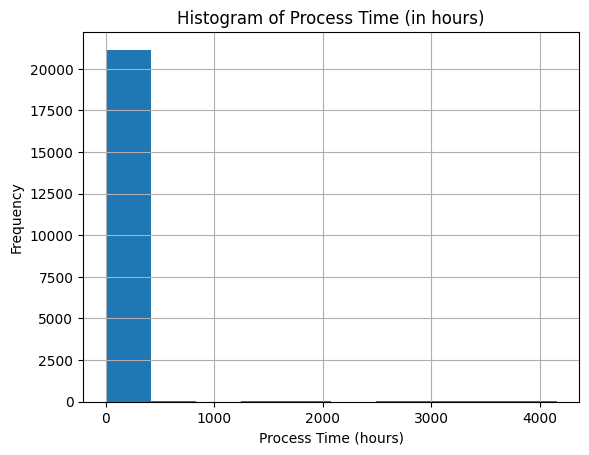

In [45]:
# Convert "Process Time" to timedelta
df["Process Time"] = pd.to_timedelta(df["Process Time"])

# Calculate statistics
mean_process_time = df["Process Time"].mean()
min_process_time = df["Process Time"].min()
max_process_time = df["Process Time"].max()

# Plot histogram (in hours for better readability)
df["Process Time (hours)"] = df["Process Time"].dt.total_seconds() / 3600

plt.hist(df["Process Time (hours)"], bins=10)
plt.title("Histogram of Process Time (in hours)")
plt.xlabel("Process Time (hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [46]:
# Log transformation 
df["Process Time (hours)"] = df["Process Time"].dt.total_seconds() / 3600
df["Log Process Time"] = np.log1p(df["Process Time (hours)"])  # log(1 + x) to handle 0s

### 1.3 Filter by 2020 Ridge Routes

In [47]:
# Street address value counts
address_counts = df["Street Address"].value_counts().reset_index()
address_counts.columns = ["Street Address", "Count"]

In [48]:
# List of valid addresses
valid_addresses = [
    "2020 Ridge", "1007 Church Street", "1201 Davis Street", "1603 Orrington Avenue",
    "1800 Sherman Avenue", "1801 Hinman Avenue", "1801 Maple Avenue", "1808 Chicago Avenue",
    "1809 Chicago Avenue", "1810 Chicago Avenue", "1812 Chicago Avenue", "1810 Hinman Avenue",
    "1813 Hinman Avenue", "1815 Chicago Avenue", "1818 Hinman Avenue", "1819 Hinman Avenue",
    "1902 Sheridan Road", "1908 Sheridan Road", "1914 Sheridan Road", "1918 Sheridan Road",
    "1936 Sheridan Road", "1940 Sheridan Road", "2000 Sheridan Road", "2006 Sheridan Road",
    "2010 Sheridan Road", "2016 Sheridan Road", "2040 Sheridan Road", "2046 Sheridan Road",
    "2122 Sheridan Road", "405 Church Street", "515 Clark Street", "555 Clark Street",
    "600 Haven Street", "616 Noyes Street", "617 Dartmouth Place", "617 Haven Street",
    "617 Library Place", "617 Noyes Street", "618 Emerson Street", "618 Garrett Place",
    "619 Clark Street", "619 Emerson Street", "619 University Place", "620 Library Place",
    "620 Lincoln Street", "625 Haven Street", "625 University Place", "626 Library Place",
    "627 Dartmouth Place", "629 Colfax Street", "629 Noyes Street", "630 Dartmouth Place",
    "630 Emerson Street", "630 Lincoln Street", "637 University Place", "701 University Place",
    "710 Emerson Street", "711 University Place", "720 Emerson Street", "720 University Place",
    "2169 Campus Drive", "1820 Chicago Avenue", "2701 Ashland Avenue", "2120 Campus Drive",
    "1920 Campus Drive", "40 Arts Circle Drive", "617 Foster Street", "600 Emerson Street",
    "600 Foster Street", "726 University Place", "2324 Campus Drive",
    "2021 Sheridan Road", "2131 Tech Drive", "1937 Sheridan Road",
    "2400 Sheridan Road", "1915 Maple Avenue", "721 University Place", "2026 North Campus Drive",
    "1855 Sheridan Road", "1861 Sheridan Road", "618 Library Place", "1845 Sheridan Road",
    "1927 Orrington Avenue", "2121 Sheridan Road",
    "2321 Sheridan Road", "1881 Sheridan Road", "633 Emerson Street",
    "2001 Sheridan Road", "1800 Sheridan Road", "1820 Sheridan Road",
    "2420 Campus Drive", "1880 Campus Drive", "2309 Sheridan Road", "1850 Campus Drive",
    "1877 Campus Drive", "2033 Sheridan Road", "1870 Campus Drive", "2305 Sheridan Road",
    "2705 Ashland Avenue", "1725 Orrington Avenue", "1927 Orrington Avenue", "655 University Place",
    "1870 Sheridan Road", "711 Elgin Road", "1823 Sherman Avenue",
    "1999 Campus Drive", "2200 Campus Drive", "2333 Campus Drive", "2407 Sheridan Road",
    "50 Arts Circle Drive", "633 Clark Street", "647 University Place", "70 Arts Circle Drive",
    "1501 Central Street", "1823 Campus Drive", "2245 Sheridan Road",
    "560 Lincoln Street", "601 University Place", "1841 Sheridan Road", "2031 Sheridan Road",
    "626 University Place", "2420 Campus Drive", "2311 Campus Drive",
    "2029 Sheridan Road", "1897 Sheridan Road"
]

usps_only_addresses = [
    "2145 Sheridan Road", "2133 Sheridan Road", "2137 Tech Drive", "2190 Campus Drive",
    "2170 Campus Drive", "2220 Campus Drive", "2240 Campus Drive",
    "2233 Tech Drive", "2211 Campus Drive", "1970 Campus Drive", "2205 Tech Drive"
]

In [49]:
# 1. Clean street addresses in the dataframe
df["Street Address Cleaned"] = df["Street Address"].str.upper().str.replace(
    r'\b(AVENUE|STREET|ROAD|DRIVE|CIRCLE|PLACE|LANE|COURT|TERRACE|BLVD|PARKWAY|WAY)\b', '', 
    regex=True).str.strip()

# 2. Clean carrier field for easier matching
df["Carrier Cleaned"] = df["Carrier"].str.upper().str.strip()

# 3. Prepare valid address patterns (without suffixes)
def extract_main_part(address):
    address = address.upper()
    return re.sub(r'\b(AVENUE|STREET|ROAD|DRIVE|CIRCLE|PLACE|LANE|COURT|TERRACE|BLVD|PARKWAY|WAY)\b', '', address).strip()

main_name_patterns = [extract_main_part(addr) for addr in valid_addresses]
main_name_regex = "|".join(re.escape(name) for name in main_name_patterns)

# 4. Prepare USPS-only address patterns
usps_only_addresses = [
     "2145 Sheridan Road", "2133 Sheridan Road", "2137 Tech Drive", "2190 Campus Drive",
    "2170 Campus Drive", "2220 Campus Drive", "2240 Campus Drive",
    "2233 Tech Drive", "2211 Campus Drive", "1970 Campus Drive", "2205 Tech Drive"
]
usps_only_patterns = [extract_main_part(addr) for addr in usps_only_addresses]
usps_only_regex = "|".join(re.escape(name) for name in usps_only_patterns)

# 5. Apply filtering
# Keep if:
# Matches a valid address, and
# If matches a USPS-only address, carrier must be USPS
filtered_df = df[
    (df["Street Address Cleaned"].str.contains(main_name_regex, na=False, regex=True)) &
    (
        ~df["Street Address Cleaned"].str.contains(usps_only_regex, na=False, regex=True) | 
        (df["Carrier Cleaned"] == "USPS")
    )
]

### 1.4 USPS vs Non USPS Distribution

In [50]:
# Assuming 'Carrier' column exists and needs cleaning
filtered_df["Carrier"] = filtered_df["Carrier"].str.upper().str.strip()

# Calculate USPS vs Non-USPS proportions
carrier_counts = filtered_df["Carrier Cleaned"].value_counts(normalize=True)

# Display the carrier distribution, uncomment next two lines to view
# print("Carrier Distribution (Proportion):")
# print(carrier_counts)

# Optional: store proportions for weighting later
usps_proportion = carrier_counts.get('USPS', 0)
non_usps_proportion = 1 - usps_proportion

### 1.5 Data Exploration for Arrivals - Histograms

In [51]:
# Add weekday name to the dataframe
filtered_df["Weekday"] = filtered_df["Received Timestamp"].dt.day_name()

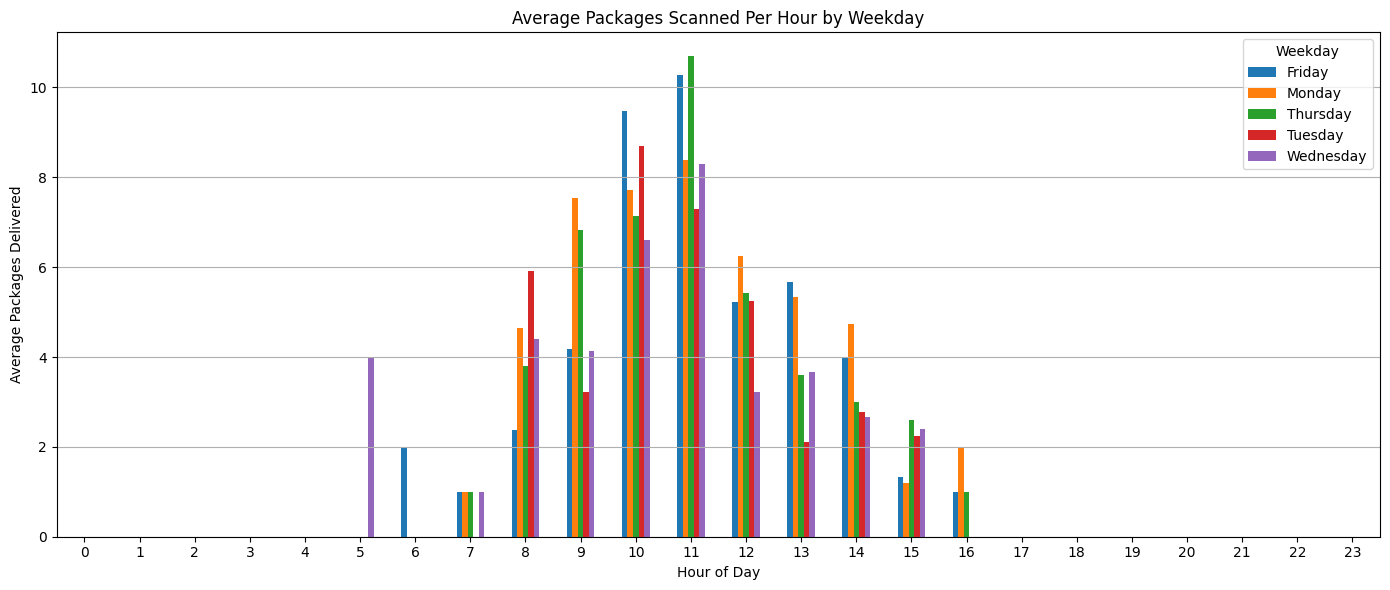

In [52]:
# Extract hour, date, and weekday name
filtered_df["Hour"] = filtered_df["Received Timestamp"].dt.hour
filtered_df["Date"] = filtered_df["Received Timestamp"].dt.date
filtered_df["Weekday"] = filtered_df["Received Timestamp"].dt.day_name()

# Filter to weekdays only (Monday to Friday)
filtered_df = filtered_df[filtered_df["Received Timestamp"].dt.dayofweek < 5]

# Group by Date, Hour, and Weekday, then count package arrivals
grouped = (
    filtered_df.groupby(["Date", "Hour", "Weekday"])
    .size()
    .reset_index(name="Package Count")
)

# Compute the average number of packages received per hour for each weekday
avg_per_hour_by_weekday = (
    grouped.groupby(["Hour", "Weekday"])["Package Count"]
    .mean()
    .unstack(fill_value=0)
    .reindex(index=range(24), fill_value=0)
)

# Plot the result
ax = avg_per_hour_by_weekday.plot(kind='bar', figsize=(14, 6))
ax.set_title("Average Packages Scanned Per Hour by Weekday")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Packages Delivered")
ax.legend(title="Weekday")
ax.grid(True, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
# Run this only if you need the file again: 
# filtered_df.to_csv('filtered_df.csv', index=False)

## 2. Input Modeling / Distributions

### 2.1 Simulating Arrivals 

In [54]:
# Step 1: Compute how many days each weekday appears
filtered_df["Weekday"] = filtered_df["Received Timestamp"].dt.dayofweek
filtered_df["Date"] = filtered_df["Received Timestamp"].dt.date
filtered_df["Hour"] = filtered_df["Received Timestamp"].dt.hour

weekday_counts = filtered_df.groupby("Weekday")["Date"].nunique()
weekday_hour_counts = filtered_df.groupby(["Weekday", "Hour"]).size()

# Step 2: Compute λ = (total package count at that weekday+hour) / (num days of that weekday)
lambda_weekday_hour = (
    weekday_hour_counts / weekday_hour_counts.index.get_level_values(0).map(weekday_counts)
)

# Step 3: Simulate one week (Mon–Fri)
simulated_arrivals = []

for day in range(5):  # Monday to Friday
    for hour in range(24):
        lam = lambda_weekday_hour.get((day, hour), 0)
        if lam > 0:
            arrivals_this_hour = np.random.poisson(lam)
            date = pd.Timestamp("2023-09-04") + pd.Timedelta(days=day)
            minute_slots = pd.date_range(
                start=f"{date.date()} {hour:02d}:00:00", periods=60, freq='T'
            )
            if arrivals_this_hour > 0:
                arrival_minutes = np.random.choice(minute_slots, size=arrivals_this_hour, replace=True)
                simulated_arrivals.extend(arrival_minutes)

# Step 4: Convert to DataFrame
simulated_df = pd.DataFrame({
    "Simulated Arrival Timestamp": sorted(simulated_arrivals)
})

In [55]:
import pandas as pd

# Convert lambda_weekday_hour Series with (Weekday, Hour) into a DataFrame
lambda_table = lambda_weekday_hour.reset_index()
lambda_table.columns = ["Weekday", "Hour of Day", "Poisson Rate λ (avg packages/hour)"]
lambda_table["Poisson Rate λ (avg packages/hour)"] = lambda_table["Poisson Rate λ (avg packages/hour)"].round(2)

In [56]:
simulated_df["Date"] = simulated_df["Simulated Arrival Timestamp"].dt.date
daily_counts = simulated_df.groupby("Date").size()
print("Average Daily Package Count:", daily_counts.mean())

Average Daily Package Count: 34.0


### 2.2 Simulating Delivery Times

In [57]:
# Define PERT sampling function
def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size) * (maximum - minimum) + minimum

# Updated stop count data (removed "red", added "chicago")
stops_per_route = {
    "blue":    {"Monday": 10, "Tuesday": 7, "Wednesday": 10, "Thursday": 7, "Friday": 6},
    "green":   {"Monday": 13, "Tuesday": 6, "Wednesday": 13, "Thursday": 6, "Friday": 15},
    "yellow":  {"Monday": 21, "Tuesday": 16, "Wednesday": 21, "Thursday": 16, "Friday": 2},
    "chicago": {"Monday": 1, "Tuesday": 1, "Wednesday": 1, "Thursday": 1, "Friday": 1}
}

# Define PERT parameters for driving and per-stop time (in minutes)
drive_time_params = {"min": 10, "mode": 11.5, "max": 13}
stop_time_params = {"min": 0.5, "mode": 1, "max": 5}
long_stop_1_params = {"minimum": 30, "mode": 45, "maximum": 60}
long_stop_2_params = {"minimum": 15, "mode": 20, "maximum": 20}  # mode = max to reflect upper bound only

# Create scaled delivery time samples for each route and day
samples = []

for route, days in stops_per_route.items():
    for day, num_stops in days.items():
        if route == "chicago":
            total_delivery_time = 5 * 60 + 45  # 5 hours 45 minutes
            drive_time = np.nan
            stop_time_total = np.nan
        else:
            drive_time = sample_pert(drive_time_params["min"], drive_time_params["mode"], drive_time_params["max"])[0]
            regular_stops = num_stops

            # Subtract special stops from regular stop count for blue route
            if route == "blue":
                regular_stops -= 2
                regular_stop_times = sample_pert(stop_time_params["min"], stop_time_params["mode"], stop_time_params["max"], size=regular_stops)
                special1 = sample_pert(**long_stop_1_params)[0]
                special2 = sample_pert(**long_stop_2_params)[0]
                stop_time_total = regular_stop_times.sum() + special1 + special2
            else:
                stop_times = sample_pert(stop_time_params["min"], stop_time_params["mode"], stop_time_params["max"], size=num_stops)
                stop_time_total = stop_times.sum()

            total_delivery_time = drive_time + stop_time_total

        samples.append({
            "Route": route.capitalize(),
            "Day": day,
            "Stops": num_stops,
            "Drive Time (min)": round(drive_time, 2) if not pd.isna(drive_time) else "Fixed",
            "Stop Time Total (min)": round(stop_time_total, 2) if not pd.isna(stop_time_total) else "Fixed",
            "Total Delivery Time (min)": round(total_delivery_time, 2)
        })

delivery_df = pd.DataFrame(samples)

## 3. Simulations

### 3.1 Current Configuration

In [58]:
from datetime import time

# Sample lambda_weekday_hour already loaded earlier in session (assumed)
lambda_weekday_hour = lambda_weekday_hour

# Constants
NUM_CLERKS = 2
CLERK_SHIFT_HOURS = 8.5  # 8:00 AM – 4:30 PM
NUM_DRIVERS = 4
DRIVER1_SHIFT_HOURS = 8.5  # 7:30 AM – 4:00 PM
DRIVER2_SHIFT_HOURS = 8.5  # 8:00 AM – 4:30 PM

# Assume PERT parameters are provided
def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size) * (maximum - minimum) + minimum

drive_time_params = {"min": 10, "mode": 11.5, "max": 13}
stop_time_params = {"min": 0.5, "mode": 1, "max": 5}

stops_per_route = {
    "blue":    {"Monday": 10, "Tuesday": 7, "Wednesday": 10, "Thursday": 7, "Friday": 6},
    "green":   {"Monday": 13, "Tuesday": 6, "Wednesday": 13, "Thursday": 6, "Friday": 15},
    "yellow":  {"Monday": 21, "Tuesday": 16, "Wednesday": 21, "Thursday": 16, "Friday": 2},
    "chicago": {"Monday": 1, "Tuesday": 1, "Wednesday": 1, "Thursday": 1, "Friday": 1}
}

# Simulation function
def run_single_simulation():
    simulated_arrivals_all_days = []
    for day in range(5):  # Monday to Friday
        for hour in range(5, 17):  # 5AM to 4PM
            lam = lambda_weekday_hour.get((day, hour), 0)
            if lam > 0:
                arrivals_this_hour = np.random.poisson(lam)
                date = pd.Timestamp("2023-09-04") + pd.Timedelta(days=day)
                minute_slots = pd.date_range(start=f"{date.date()} {hour:02d}:00:00", periods=60, freq='T')
                if arrivals_this_hour > 0:
                    arrival_minutes = np.random.choice(minute_slots, size=arrivals_this_hour, replace=True)
                    for ts in arrival_minutes:
                        simulated_arrivals_all_days.append({
                            "Simulated Arrival Timestamp": ts,
                            "Day": date.day_name()
                        })

    arrivals_df = pd.DataFrame(simulated_arrivals_all_days)
    if arrivals_df.empty:
        return {"Clerk Utilization": 0, "Driver Sorting Utilization": 0, "Driver Total Utilization": 0, "Packages": 0}

    arrivals_df["Sorting Time (min)"] = sample_pert(0.5, 1, 2, size=len(arrivals_df))
    arrivals_df["Sort Time"] = arrivals_df["Simulated Arrival Timestamp"].dt.time
    before_9am = arrivals_df[arrivals_df["Sort Time"] < time(8, 0)]["Sorting Time (min)"].sum()
    after_9am = arrivals_df[arrivals_df["Sort Time"] >= time(8, 0)]["Sorting Time (min)"].sum()

    total_delivery_time = 0
    for day in range(5):
        date = pd.Timestamp("2023-09-04") + pd.Timedelta(days=day)
        weekday = date.day_name()
        for route, days in stops_per_route.items():
            if weekday in days:
                if route == "chicago":
                    total_delivery_time += 345
                else:
                    num_stops = days[weekday]
                    drive = sample_pert(drive_time_params["min"], drive_time_params["mode"], drive_time_params["max"])[0]
                    if route == "blue":
                        long_stop = sample_pert(30, 45, 60)[0]
                        mid_stop = sample_pert(15, 20, 20)[0]
                        remaining_stops = num_stops - 2
                        regular_stops = sample_pert(stop_time_params["min"], stop_time_params["mode"], stop_time_params["max"], size=remaining_stops)
                        stop_total = long_stop + mid_stop + regular_stops.sum()
                    else:
                        stop_times = sample_pert(stop_time_params["min"], stop_time_params["mode"], stop_time_params["max"], size=num_stops)
                        stop_total = stop_times.sum()
                    total_delivery_time += drive + stop_total

    clerk_time = NUM_CLERKS * CLERK_SHIFT_HOURS * 60
    driver_sorting_time = 4 * 60
    driver_total_time = (2 * DRIVER1_SHIFT_HOURS + 2 * DRIVER2_SHIFT_HOURS) * 60

    return {
        "Clerk Utilization": after_9am / clerk_time,
        "Driver Sorting Utilization": before_9am / driver_sorting_time,
        "Driver Total Utilization": (before_9am + total_delivery_time / NUM_DRIVERS) / driver_total_time,
        "Packages": len(arrivals_df)
    }

# Run simulation
results = [run_single_simulation() for _ in range(1000)]
results_df = pd.DataFrame(results)
results_df

,Clerk Utilization,Driver Sorting Utilization,Driver Total Utilization,Packages
0,0.196587,0.000000,0.303292,176
1,0.160211,0.004734,0.303329,150
2,0.177451,0.004160,0.303978,169
3,0.188740,0.007076,0.301756,182
4,0.163479,0.004109,0.302019,158
...,...,...,...,...
995,0.162323,0.003209,0.303117,151
996,0.173618,0.005007,0.305312,163
997,0.176948,0.005174,0.305368,166
998,0.159118,0.000000,0.300565,156


In [59]:
averages_only = results_df.mean().to_frame(name="Average Value").reset_index()
averages_only.rename(columns={"index": "Metric"}, inplace=True)
averages_only

,Metric,Average Value
0,Clerk Utilization,0.174277
1,Driver Sorting Utilization,0.002905
2,Driver Total Utilization,0.302994
3,Packages,164.763000


## 4. Simulation with Scheduling

### 4.1 Non-Flex: Two 4-hour shifts each day, Drivers' real behavior (don't stop at all stops) is modeled, Tests all clerks and driver combinations

In [60]:
lambda_weekday_hour = pd.Series({
    **{(0, h): 4.0 for h in range(7, 17)},  # Monday
    **{(1, h): 4.0 for h in range(7, 17)},  # Tuesday
    **{(2, h): 4.0 for h in range(7, 17)},  # Wednesday
    **{(3, h): 4.0 for h in range(7, 17)},  # Thursday
    **{(4, h): 4.0 for h in range(7, 17)},  # Friday
})

def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta  = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size=size) * (maximum - minimum) + minimum

# Service time parameters
clerk_sort_params   = {"minimum": 0.5, "mode": 1, "maximum": 2}   # min/mode/max scan mins
drive_time_params   = {"minimum": 10,  "mode": 11.5, "maximum": 13}  # drive mins
driver_stop_params  = {"minimum": 0.5, "mode": 1, "maximum": 5}    # per‐stop mins

# Per‐route stop probabilities
stop_probs = {"blue":1.0, "chicago":1.0, "green":0.5, "yellow":0.5}
full_stop_chance = 0.05  # 5% override to always serve all stops

stops_per_route = {
    "blue":    {"Monday":10, "Tuesday":7,  "Wednesday":10, "Thursday":7,  "Friday":6},
    "green":   {"Monday":13, "Tuesday":6,  "Wednesday":13, "Thursday":6,  "Friday":15},
    "yellow":  {"Monday":21, "Tuesday":16, "Wednesday":21, "Thursday":16, "Friday":2},
    "chicago": {"Monday":1,  "Tuesday":1,  "Wednesday":1,  "Thursday":1,  "Friday":1}
}

# Single shift simulation where clerks scan PERT(min=0.5,mode=1,max=2) per package, get +10% outbound delivery credit, drivers 
# sort 60 min before departure, and drivers serve each route probabilistically 
def simulate_shift(day_idx, num_clerks, num_drivers, shift_start, shift_end):
    s_min = shift_start.hour*60 + shift_start.minute
    e_min = shift_end.hour*60   + shift_end.minute
    shift_len = e_min - s_min

    # 1. Arrivals
    arrivals = []
    for hr in range(shift_start.hour, shift_end.hour):
        lam = lambda_weekday_hour.get((day_idx, hr), 0)
        cnt = np.random.poisson(lam) if lam>0 else 0
        offs = np.random.randint(0,60,size=cnt) + hr*60
        arrivals += [o - s_min for o in offs if s_min <= o < e_min]
    n_pkg = len(arrivals)

    # 2. Clerk scanning
    scan_times = sample_pert(**clerk_sort_params, size=n_pkg)
    total_scan = scan_times.sum()
    clerk_util = total_scan / (num_clerks * shift_len) * 100
    clerk_util = min(clerk_util + 10.0, 100.0)

    # 3. Driver sort (fixed 60 min)
    depart_offset = (total_scan / num_clerks) + 60.0

    # 4. Delivery work (probabilistic stops)
    day_name = ["Monday","Tuesday","Wednesday","Thursday","Friday"][day_idx]
    total_del = 0.0
    for route, sched in stops_per_route.items():
        nst = sched[day_name]
        # Decide served stops
        if np.random.rand() < full_stop_chance:
            served = nst
        else:
            served = int(np.random.binomial(nst, stop_probs[route]))
        # Compute route time +20 min going back if call received
        if route=="chicago":
            rt = 5*60 + 45 + 20
        else:
            dt = sample_pert(**drive_time_params)[0]
            if route=="blue" and served>=2:
                l1  = sample_pert(30,45,60)[0]
                l2  = sample_pert(15,20,20)[0]
                rest= served-2
                stp = sample_pert(**driver_stop_params, size=rest).sum()
                rt  = dt + l1 + l2 + stp + 20
            else:
                stp = sample_pert(**driver_stop_params, size=served).sum()
                rt  = dt + stp + 20
        total_del += rt

    # 5. Driver driving utilization
    drive_window = max(shift_len - depart_offset, 1e-6)
    driver_util  = (total_del/num_drivers) / (drive_window * num_drivers) * 100

    # 6. Overall utilization
    overall_util = (clerk_util + driver_util) / 2

    # 7. Avg finish time (midpoint of driving)
    avg_finish = depart_offset + (total_del/num_drivers)/2
    fh = int(avg_finish//60); fm = int(avg_finish%60)
    avg_finish_str = f"{fh:02d}:{fm:02d}"

    return clerk_util, driver_util, overall_util, n_pkg, avg_finish_str

# Monte Carlo repetitions
REPS = 500
shift_defs = [("7:30–11:30", time(7,30), time(11,30)),
              ("12:00–16:00", time(12,0), time(16,0))]

results = []
for day_idx in range(5):
    day_str = ["Mon","Tue","Wed","Thu","Fri"][day_idx]
    for label, st, et in shift_defs:
        for c in range(1,3):
            for d in range(1,5):
                acc = {"cu":0,"du":0,"ou":0,"pk":0}
                finish_times = []
                for _ in range(REPS):
                    cu, du, ou, pk, ft = simulate_shift(day_idx, c, d, st, et)
                    acc["cu"] += cu; acc["du"] += du; acc["ou"] += ou; acc["pk"] += pk
                    finish_times.append(ft)
                cu_avg = acc["cu"]/REPS
                du_avg = acc["du"]/REPS
                ou_avg = acc["ou"]/REPS
                pk_avg = acc["pk"]/REPS
                ft_mode = max(set(finish_times), key=finish_times.count)

                results.append({
                    "Day": day_str, "Shift": label,
                    "Clerks": c, "Drivers": d,
                    "Clerk Util (%)": f"{cu_avg:.1f}%",
                    "Driver Util (%)": f"{du_avg:.1f}%",
                    "Overall Util (%)": f"{ou_avg:.1f}%",
                    "AvgPackages": round(pk_avg,1),
                    "AvgFinishTime": ft_mode
                })

# Scheduling dataframe
df = pd.DataFrame(results)
df['Day'] = pd.Categorical(df['Day'],
                           categories=["Mon","Tue","Wed","Thu","Fri"], ordered=True)
df = df.sort_values(['Day','Shift','Clerks','Drivers']).reset_index(drop=True)
print(df.to_string(index=False))

Day       Shift  Clerks  Drivers Clerk Util (%) Driver Util (%) Overall Util (%)  AvgPackages AvgFinishTime
Mon 12:00–16:00       1        1          17.3%          347.5%           182.4%         16.1         05:59
Mon 12:00–16:00       1        2          17.3%           87.0%            52.2%         16.2         03:37
Mon 12:00–16:00       1        3          17.1%           38.5%            27.8%         15.8         02:50
Mon 12:00–16:00       1        4          17.1%           21.7%            19.4%         15.8         02:26
Mon 12:00–16:00       2        1          13.7%          330.0%           171.8%         16.2         05:51
Mon 12:00–16:00       2        2          13.7%           82.4%            48.0%         16.2         03:30
Mon 12:00–16:00       2        3          13.6%           36.6%            25.1%         16.0         02:42
Mon 12:00–16:00       2        4          13.6%           20.6%            17.1%         15.9         02:18
Mon  7:30–11:30       1     

In [61]:
# Safe and simplified version for computing average utilization by Clerks and Drivers
# Ensure utilization columns are converted if they exist

util_cols = ["Clerk Util (%)", "Driver Util (%)", "Overall Util (%)"]
for col in util_cols:
    if col in df.columns and df[col].dtype == object:
        df[col] = df[col].str.rstrip('%').astype(float)

# Filter to only the columns that exist
available_cols = [col for col in util_cols if col in df.columns]

# Compute group-wise averages if relevant columns are available
if "Clerks" in df.columns and "Drivers" in df.columns and available_cols:
    avg_by_clerks_drivers = (
        df.groupby(["Clerks", "Drivers"])[available_cols]
        .mean()
        .round(1)
        .reset_index()
    )
else:
    avg_by_clerks_drivers = pd.DataFrame(columns=["Clerks", "Drivers"] + available_cols)

avg_by_clerks_drivers

,Clerks,Drivers,Clerk Util (%),Driver Util (%),Overall Util (%)
0,1,1,16.8,338.9,177.8
1,1,2,16.7,84.7,50.7
2,1,3,16.7,37.6,27.2
3,1,4,16.7,21.2,19.0
4,2,1,13.4,322.8,168.1
5,2,2,13.4,80.7,47.0
6,2,3,13.4,35.8,24.6
7,2,4,13.4,20.2,16.8


### 4.2 Non-Flex: Two 4-hour shifts each day, Drivers' IDEAL behavior (stop at all stops) is modeled, Tests all combos of clerks and drivers

In [62]:
lambda_weekday_hour = pd.Series({
    **{(0, h): 4.0 for h in range(7, 17)},  # Monday
    **{(1, h): 4.0 for h in range(7, 17)},  # Tuesday
    **{(2, h): 4.0 for h in range(7, 17)},  # Wednesday
    **{(3, h): 4.0 for h in range(7, 17)},  # Thursday
    **{(4, h): 4.0 for h in range(7, 17)},  # Friday
})

def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta  = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size=size) * (maximum - minimum) + minimum

clerk_sort_params   = {"minimum": 0.5, "mode": 1,   "maximum": 2}   # per‐pkg scan time
driver_stop_params  = {"minimum": 0.5, "mode": 1,   "maximum": 5}   # per‐stop service time
drive_time_params   = {"minimum": 10,  "mode": 11.5,"maximum": 13}  # drive between stops

stops_per_route = {
    "blue":    {"Monday":10, "Tuesday":7,  "Wednesday":10, "Thursday":7,  "Friday":6},
    "green":   {"Monday":13, "Tuesday":6,  "Wednesday":13, "Thursday":6,  "Friday":15},
    "yellow":  {"Monday":21, "Tuesday":16, "Wednesday":21, "Thursday":16, "Friday":2},
    "chicago": {"Monday":1,  "Tuesday":1,  "Wednesday":1,  "Thursday":1,  "Friday":1}
}

def simulate_shift(day_idx, c, d, shift_start, shift_end):
    # Convert shift window to minutes since midnight
    s_min = shift_start.hour * 60 + shift_start.minute
    e_min = shift_end.hour   * 60 + shift_end.minute
    shift_len = e_min - s_min

    # 1. Package arrivals during shift
    arrivals = []
    for hr in range(shift_start.hour, shift_end.hour):
        lam = lambda_weekday_hour.get((day_idx, hr), 0)
        if lam > 0:
            cnt  = np.random.poisson(lam)
            offs = np.random.randint(0, 60, size=cnt) + hr*60
            arrivals += [o - s_min for o in offs if s_min <= o < e_min]
    n_pkg = len(arrivals)

    # 2. Clerk scanning time (PERT per package)
    scan_times = sample_pert(**clerk_sort_params, size=n_pkg)
    total_scan = scan_times.sum()
    clerk_util  = total_scan / (c * shift_len) * 100
    # Add 10 percentage points for outbound delivery work
    clerk_util = min(clerk_util + 10.0, 100.0)

    # 3. Driver pre‐delivery sorting: fixed 45 minutes total
    driver_sort_time = 45.0
    # drivers depart after scan + fixed sort
    depart_offset    = total_scan / c + driver_sort_time

    # 4. Delivery: all drivers stop at every scheduled stop
    day_name = ["Monday","Tuesday","Wednesday","Thursday","Friday"][day_idx]
    total_drive_work = 0.0
    for route, sched in stops_per_route.items():
        nst = sched[day_name]
        # Route time calculation
        if route == "chicago":
            rt = 5*60 + 45   # Fixed + buffer
        else:
            drive_t = sample_pert(**drive_time_params)[0]
            # Blue has two long stops
            if route == "blue" and nst >= 2:
                l1 = sample_pert(30,45,60)[0]
                l2 = sample_pert(15,20,20)[0]
                rest = nst - 2
                stp  = sample_pert(**driver_stop_params, size=rest).sum()
                rt   = drive_t + l1 + l2 + stp
            else:
                stp = sample_pert(**driver_stop_params, size=nst).sum()
                rt  = drive_t + stp
        total_drive_work += rt

    # 5. Driver driving utilization
    drive_window = max(shift_len - depart_offset, 1e-6)
    driver_util  = (total_drive_work / d) / (drive_window * d) * 100

    # 6. Overall utilization (average of clerk + driver)
    # Overall utilization is weighted by number of clerks and drivers
    total_workers = c + d
    overall_util = (clerk_util * c + driver_util * d) / total_workers

    # 7. Approx average finish time (midpoint of drive work)
    avg_finish = depart_offset + (total_drive_work / d) / 2
    fh = int(avg_finish // 60)
    fm = int(avg_finish % 60)
    avg_finish_str = f"{fh:02d}:{fm:02d}"

    return clerk_util, driver_util, overall_util, n_pkg, avg_finish_str

REPS = 500
shift_defs = [
    ("7:30–11:30", time(7,30), time(11,30)),
    ("12:00–16:00", time(12,0), time(16,0))
]

rows = []
for day in range(5):
    day_str = ["Mon","Tue","Wed","Thu","Fri"][day]
    for label, st, et in shift_defs:
        for c in range(1, 3):      # 1–2 clerks
            for d in range(1, 5):  # 1–4 drivers
                acc = {"cu":0, "du":0, "ou":0, "pk":0}
                times = []
                for _ in range(REPS):
                    cu, du, ou, pk, ft = simulate_shift(day, c, d, st, et)
                    acc["cu"] += cu
                    acc["du"] += du
                    acc["ou"] += ou
                    acc["pk"] += pk
                    times.append(ft)
                cu_avg = acc["cu"] / REPS
                du_avg = acc["du"] / REPS
                ou_avg = acc["ou"] / REPS
                pk_avg = acc["pk"] / REPS
                # mode of finish times for consistency
                ft_mode = max(set(times), key=times.count)

                rows.append({
                    "Day": day_str,
                    "Shift": label,
                    "Clerks": c,
                    "Drivers": d,
                    "Clerk Util (%)":      f"{cu_avg:.1f}%",
                    "Driver Util (%)":     f"{du_avg:.1f}%",
                    "Overall Util (%)":    f"{ou_avg:.1f}%",
                    "AvgPackages":         round(pk_avg,1),
                    "AvgFinishTime":       ft_mode
                })

df = pd.DataFrame(rows)
df['Day'] = pd.Categorical(df['Day'],
                           categories=["Mon","Tue","Wed","Thu","Fri"],
                           ordered=True)
df = df.sort_values(['Day','Shift','Clerks','Drivers']).reset_index(drop=True)

print(df.to_string(index=False))

Day       Shift  Clerks  Drivers Clerk Util (%) Driver Util (%) Overall Util (%)  AvgPackages AvgFinishTime
Mon 12:00–16:00       1        1          17.2%          287.0%           152.1%         15.8         05:16
Mon 12:00–16:00       1        2          17.2%           71.8%            53.6%         16.0         03:10
Mon 12:00–16:00       1        3          17.2%           31.9%            28.2%         16.0         02:25
Mon 12:00–16:00       1        4          17.0%           17.9%            17.7%         15.7         02:04
Mon 12:00–16:00       2        1          13.6%          274.1%           100.4%         16.1         05:08
Mon 12:00–16:00       2        2          13.6%           68.6%            41.1%         16.1         03:02
Mon 12:00–16:00       2        3          13.6%           30.4%            23.7%         15.9         02:18
Mon 12:00–16:00       2        4          13.7%           17.1%            16.0%         16.2         01:57
Mon  7:30–11:30       1     

In [63]:
# Safe and simplified version for computing average utilization by Clerks and Drivers
# Only check and convert columns that exist

for col in ["Clerk Util (%)", "Driver Util (%)", "Overall Util (%)"]:
    if col in df.columns and df[col].dtype == object:
        df[col] = df[col].str.rstrip('%').astype(float)

# Only use the columns that are available
existing_cols = [col for col in ["Clerk Util (%)", "Driver Util (%)", "Overall Util (%)"] if col in df.columns]

# Group and average if valid columns exist
if "Clerks" in df.columns and "Drivers" in df.columns and existing_cols:
    avg_util = (
        df.groupby(["Clerks", "Drivers"])[existing_cols]
        .mean()
        .round(1)
        .reset_index()
    )
    avg_util
else:
    print("The necessary columns are not present in the DataFrame.")

avg_util

,Clerks,Drivers,Clerk Util (%),Driver Util (%),Overall Util (%)
0,1,1,16.7,276.5,146.6
1,1,2,16.8,69.1,51.7
2,1,3,16.8,30.7,27.2
3,1,4,16.8,17.3,17.2
4,2,1,13.4,264.4,97.1
5,2,2,13.4,66.1,39.8
6,2,3,13.4,29.4,23.0
7,2,4,13.4,16.5,15.5


### 4.3 Flex Positions: Ideal Drivers' Behavior (stop at all stops)

In [64]:
lambda_weekday_hour = pd.Series({
    **{(0, h): 4.0 for h in range(7, 17)},  # Monday
    **{(1, h): 4.0 for h in range(7, 17)},  # Tuesday
    **{(2, h): 4.0 for h in range(7, 17)},  # Wednesday
    **{(3, h): 4.0 for h in range(7, 17)},  # Thursday
    **{(4, h): 4.0 for h in range(7, 17)},  # Friday
})

def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta  = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size=size) * (maximum - minimum) + minimum

clerk_sort_params   = {"minimum": 0.5, "mode": 1,   "maximum": 2}   # per‐pkg scan
driver_stop_params  = {"minimum": 0.5, "mode": 1,   "maximum": 5}   # per‐stop service
drive_time_params   = {"minimum": 10,  "mode": 11.5,"maximum": 13}  # drive between stops
driver_sort_time    = 0  # 0

# Per‐route service probabilities
stop_probs = {
    "blue":    1.0,   # always stop
    "chicago": 1.0,
    "green":   0.5,
    "yellow":  0.5
}
full_stop_chance = 0.05  # 5% override to serve all stops

stops_per_route = {
    "blue":    {"Monday":10, "Tuesday":7,  "Wednesday":10, "Thursday":7,  "Friday":6},
    "green":   {"Monday":13, "Tuesday":6,  "Wednesday":13, "Thursday":6,  "Friday":15},
    "yellow":  {"Monday":21, "Tuesday":16, "Wednesday":21, "Thursday":16, "Friday":2},
    "chicago": {"Monday":1,  "Tuesday":1,  "Wednesday":1,  "Thursday":1,  "Friday":1}
}

def simulate_shift(day_idx, workers, shift_start, shift_end):
    # shift in minutes
    s_min = shift_start.hour*60 + shift_start.minute
    e_min = shift_end.hour*60   + shift_end.minute
    shift_len = e_min - s_min

    # 1. Arrivals during shift
    arrivals = []
    for hr in range(shift_start.hour, shift_end.hour):
        lam = lambda_weekday_hour.get((day_idx, hr), 0)
        cnt = np.random.poisson(lam) if lam > 0 else 0
        offs = np.random.randint(0, 60, size=cnt) + hr*60
        arrivals += [o - s_min for o in offs if s_min <= o < e_min]
    n_pkg = len(arrivals)

    # 2. Clerk scan time
    scan_times = sample_pert(**clerk_sort_params, size=n_pkg)
    total_scan = scan_times.sum()

    # 3. Driver pre‐delivery sort
    # Depart after scan per clerk + fixed sort
    depart_offset = (total_scan / workers) + driver_sort_time

    # 4. Delivery work with probabilistic stops
    day_name = ["Monday","Tuesday","Wednesday","Thursday","Friday"][day_idx]
    total_drive = 0.0
    for route, sched in stops_per_route.items():
        nst = sched[day_name]
        # Decide stops served
        if np.random.rand() < full_stop_chance:
            served = nst
        else:
            served = int(np.random.binomial(nst, stop_probs[route]))
        # Compute route time + buffer
        if route == "chicago":
            rt = 5*60 + 45 + 20
        else:
            dt = sample_pert(**drive_time_params)[0]
            if route == "blue" and served >= 2:
                l1  = sample_pert(30,45,60)[0]
                l2  = sample_pert(15,20,20)[0]
                stp = sample_pert(**driver_stop_params, size=served-2).sum()
                rt  = dt + l1 + l2 + stp + 20
            else:
                stp = sample_pert(**driver_stop_params, size=served).sum()
                rt  = dt + stp + 20
        total_drive += rt

    # 5. Flex utilization: Conservative "max of scanning and delivery"
    scan_time_per_worker = total_scan / workers
    drive_time_per_worker = total_drive / workers
    max_time_per_worker = max(scan_time_per_worker, drive_time_per_worker)
    flex_util = max_time_per_worker / shift_len * 100

    # 6. Avg finish time (midpoint of delivery)
    avg_finish = depart_offset + (total_drive / workers) / 2
    fh = int(avg_finish // 60)
    fm = int(avg_finish % 60)
    finish_str = f"{fh:02d}:{fm:02d}"

    return flex_util, n_pkg, finish_str

REPS = 500
shift_defs = [
    ("7:30–11:30", time(7,30), time(11,30)),
    ("12:00–16:00", time(12,0), time(16,0))
]

rows = []
for day_idx in range(5):
    day_str = ["Mon","Tue","Wed","Thu","Fri"][day_idx]
    for label, st, et in shift_defs:
        for w in range(1, 7):
            acc_util, acc_pk = 0, 0
            times = []
            for _ in range(REPS):
                u, pk, ft = simulate_shift(day_idx, w, st, et)
                acc_util += u
                acc_pk   += pk
                times.append(ft)
            util_avg = acc_util / REPS
            pk_avg   = acc_pk / REPS
            ft_mode  = max(set(times), key=times.count)
            rows.append({
                "Day": day_str,
                "Shift": label,
                "Workers": w,
                "Flex Util (%)": f"{util_avg:.1f}%",
                "AvgPackages": round(pk_avg,1),
                "AvgFinishTime": ft_mode
            })

df = pd.DataFrame(rows)
df['Day'] = pd.Categorical(df['Day'],
                           categories=["Mon","Tue","Wed","Thu","Fri"],
                           ordered=True)
df = df.sort_values(['Day','Shift','Workers']).reset_index(drop=True)

print(df.to_string(index=False))

Day       Shift  Workers Flex Util (%)  AvgPackages AvgFinishTime
Mon 12:00–16:00        1        235.4%         16.5         04:59
Mon 12:00–16:00        2        117.7%         16.3         02:30
Mon 12:00–16:00        3         78.4%         16.2         01:39
Mon 12:00–16:00        4         58.8%         16.6         01:14
Mon 12:00–16:00        5         47.1%         16.0         00:59
Mon 12:00–16:00        6         39.2%         16.1         00:49
Mon  7:30–11:30        1        235.1%         14.2         04:58
Mon  7:30–11:30        2        117.5%         14.1         02:28
Mon  7:30–11:30        3         78.4%         14.0         01:38
Mon  7:30–11:30        4         58.7%         13.9         01:13
Mon  7:30–11:30        5         47.1%         14.1         00:58
Mon  7:30–11:30        6         39.2%         14.1         00:49
Tue 12:00–16:00        1        229.1%         16.3         04:52
Tue 12:00–16:00        2        114.5%         16.0         02:25
Tue 12:00–

In [65]:
# Easy way to view
# Convert "Flex Util (%)" column to float if it's stored as string
if df["Flex Util (%)"].dtype == object:
    df["Flex Util (%)"] = df["Flex Util (%)"].str.rstrip('%').astype(float)

# Group by number of workers and compute the average flex utilization
avg_flex_util = (
    df.groupby("Workers")[["Flex Util (%)"]]
    .mean()
    .round(1)
    .reset_index()
)

# Display the result
avg_flex_util

,Workers,Flex Util (%)
0,1,231.0
1,2,115.5
2,3,77.1
3,4,57.8
4,5,46.2
5,6,38.5


## 5. Amount of Packages Needed to Reach 70% Utilization (Current State of Non-flex: 2 Clerks, 4 Drivers)

In [66]:
def pert_mean(params):
    # Mean of a PERT(min, mode, max) distribution
    return (params['minimum'] + 4*params['mode'] + params['maximum']) / 6.0

def clerk_rate_for_util(num_clerks, scan_params, target_util=0.70):
    # util = (λ * mean_scan) / (num_clerks * 60)
    # λ = util * num_clerks * 60 / mean_scan
    mean_scan = pert_mean(scan_params)  # minutes per package
    return target_util * num_clerks * 60.0 / mean_scan

def driver_rate_for_util(num_drivers,
                         drive_params, stop_params,
                         return_buffer=10.0, max_pk_per_trip=50,
                         target_util=0.70):
      # mean_drive = avg drive time between stops (min)
      # mean_stop  = avg service time per stop (min)
      # return_buffer per trip (min)
      # max_pk_per_trip packages per trip
      # util = (λ * (mean_drive + mean_stop + return_buffer/max_pk_per_trip)) / (num_drivers * 60)
      # λ = util * num_drivers * 60 / avg_time_per_pkg
    m_drive  = pert_mean(drive_params)
    m_stop   = pert_mean(stop_params)
    overhead = return_buffer / max_pk_per_trip
    avg_time = m_drive + m_stop + overhead  # minutes per package
    return target_util * num_drivers * 60.0 / avg_time

# Compute for current configuration
if __name__ == "__main__":
    # PERT parameters (in minutes)
    scan_params   = {"minimum": 0.5, "mode": 1,   "maximum": 2}
    drive_params  = {"minimum": 10,  "mode": 11.5, "maximum": 13}
    stop_params   = {"minimum": 0.5, "mode": 1,   "maximum": 5}

    # Compute required arrival rates
    λ_clerk  = clerk_rate_for_util(num_clerks=2, scan_params=scan_params, target_util=0.70)
    λ_driver = driver_rate_for_util(num_drivers=4,
                                    drive_params=drive_params,
                                    stop_params=stop_params,
                                    return_buffer=10.0,
                                    max_pk_per_trip=50,
                                    target_util=0.70)

    print(f"Clerks (2) need ≈ {λ_clerk:.1f} pk/hr for 70% util.")
    print(f"Drivers (4) need ≈ {λ_driver:.1f} pk/hr for 70% util.")

Clerks (2) need ≈ 77.5 pk/hr for 70% util.
Drivers (4) need ≈ 12.6 pk/hr for 70% util.


## 6. Sensitivity Analysis for our Best Solution: Flex Workers

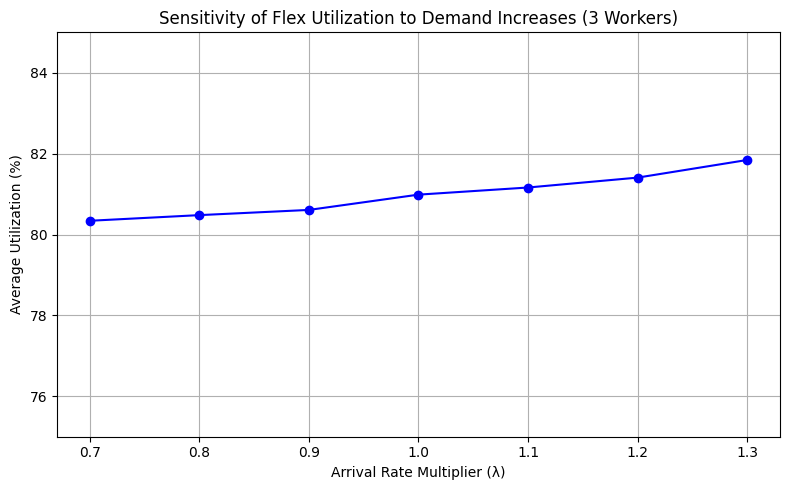

In [67]:
# Set random seed for reproducibility
np.random.seed(42)

# Service time distributions
clerk_sort_params = {"minimum": 0.5, "mode": 1, "maximum": 2}
driver_stop_params = {"minimum": 0.5, "mode": 1, "maximum": 5}
drive_time_params = {"minimum": 10, "mode": 11.5, "maximum": 13}
driver_sort_time = 0  # no additional fixed sorting time

# Arrival rate setup
base_lambda_weekday_hour = pd.Series({
    **{(0, h): 4.0 for h in range(7, 17)},
    **{(1, h): 4.0 for h in range(7, 17)},
    **{(2, h): 4.0 for h in range(7, 17)},
    **{(3, h): 4.0 for h in range(7, 17)},
    **{(4, h): 4.0 for h in range(7, 17)},
})

stops_per_route = {
    "blue":    {"Monday":10, "Tuesday":7,  "Wednesday":10, "Thursday":7,  "Friday":6},
    "green":   {"Monday":13, "Tuesday":6,  "Wednesday":13, "Thursday":6,  "Friday":15},
    "yellow":  {"Monday":21, "Tuesday":16, "Wednesday":21, "Thursday":16, "Friday":2},
    "chicago": {"Monday":1,  "Tuesday":1,  "Wednesday":1,  "Thursday":1,  "Friday":1}
}

stop_probs = {"blue": 1.0, "chicago": 1.0, "green": 0.5, "yellow": 0.5}
full_stop_chance = 0.05

def sample_pert(minimum, mode, maximum, size=1):
    alpha = (4 * (mode - minimum) / (maximum - minimum)) + 1
    beta  = (4 * (maximum - mode) / (maximum - minimum)) + 1
    return np.random.beta(alpha, beta, size=size) * (maximum - minimum) + minimum

def simulate_shift(day_idx, num_workers, shift_start, shift_end, lambda_scale):
    SHIFT_LENGTH_MIN = (shift_end.hour * 60 + shift_end.minute) - (shift_start.hour * 60 + shift_start.minute)
    
    # 1. Generate arrivals and scan times
    arrivals = []
    for hr in range(shift_start.hour, shift_end.hour):
        lam = base_lambda_weekday_hour.get((day_idx, hr), 0) * lambda_scale
        cnt = np.random.poisson(lam)
        arrivals += [sample_pert(**clerk_sort_params)[0] for _ in range(cnt)]
    total_scan_time = sum(arrivals)
    
    # 2. Sorting time proportional to number of packages (disabled here)
    sort_time = driver_sort_time  # set to 0
    
    # 3. Generate delivery times
    day_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"][day_idx]
    total_delivery_time = 0.0
    for route, sched in stops_per_route.items():
        nst = sched[day_name]
        served = nst if np.random.rand() < full_stop_chance else np.random.binomial(nst, stop_probs[route])
        if route == "chicago":
            rt = 5 * 60 + 45 + 20
        else:
            dt = sample_pert(**drive_time_params)[0]
            if route == "blue" and served >= 2:
                l1 = sample_pert(30, 45, 60)[0]
                l2 = sample_pert(15, 20, 20)[0]
                stp = sample_pert(**driver_stop_params, size=served - 2).sum()
                rt = dt + l1 + l2 + stp + 20
            else:
                stp = sample_pert(**driver_stop_params, size=served).sum()
                rt = dt + stp + 20
        total_delivery_time += rt

    # 4. Compute total work time and utilization
    total_work_time = total_scan_time + sort_time + total_delivery_time
    utilization = total_work_time / (num_workers * SHIFT_LENGTH_MIN) * 100
    return utilization

# Run sensitivity analysis for different arrival rates
scales = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
shift_start, shift_end = time(7, 30), time(11, 30)
REPS = 100
day_idx = 0  # Assume Monday for consistency

avg_utils = []
for scale in scales:
    utils = [simulate_shift(day_idx, 3, shift_start, shift_end, lambda_scale=scale) for _ in range(REPS)]
    avg_utils.append(np.mean(utils))

# Create DataFrame and plot
df_sensitivity = pd.DataFrame({
    "Arrival Rate Scale": scales,
    "Avg Flex Util (%)": avg_utils
})

# Plot
plt.figure(figsize=(8, 5))
plt.plot(scales, avg_utils, marker='o', color = 'blue', label = 'Average Utilization')
plt.title("Sensitivity of Flex Utilization to Demand Increases (3 Workers)")
plt.xlabel("Arrival Rate Multiplier (λ)")
plt.ylabel("Average Utilization (%)")
plt.grid(True)
plt.ylim(75, 85)
plt.tight_layout()
plt.show()